In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
import torch.autograd as autograd
from torch.autograd import gradcheck
from torch.utils.data import DataLoader

import random
import math
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, log_loss
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

In [2]:
# !pip install torchquantum

In [2]:
import torchquantum as tq
from torchquantum.measurement import expval_joint_analytical
import warnings

seed = 1001
#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
warnings.simplefilter('ignore', UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# NZ_INPUT_ANGLE = 2
# device = "cpu"

In [3]:
import torchvision
import torchvision.transforms 

semeion_data = torchvision.datasets.SEMEION(root='./data', download=True)
dataset_name = 'semeion'
data, label = semeion_data.data, semeion_data.labels
data = data/255*math.pi*0.25 # pi/2
n_qubits = 8
n_class = len(np.unique(label))

data = torch.nn.AvgPool2d( (2,2), stride=(2,2) )( torch.from_numpy(data) ) # # (1593, 16, 16) => (1593, 8, 8)
data = data.reshape(-1,data.shape[1]*data.shape[2]) # (1593, 8, 8) => (1593, 64)
label = torch.from_numpy(label)
n_data, n_features = data.shape

Files already downloaded and verified


In [4]:
class CoeffLayer(nn.Module):
    def __init__(self, coeff):
        super().__init__()
        self.coeff = torch.nn.Parameter(coeff)
    def forward(self, x):
        ret = x * self.coeff
        return ret

class ConstCoeffLayer(nn.Module):
    def __init__(self, coeff):
        super().__init__()
        self.coeff = coeff
    def forward(self, x):
        ret = x * self.coeff
        return ret

In [5]:
class QNNsubModel(nn.Module):
    def __init__(self):
        # params is numpy array
        super().__init__()
        self.n_wires = n_qubits
        self.encoder_gates_x = ([tq.functional.rx] * self.n_wires + [tq.functional.ry] * self.n_wires)*2
        self.n_block = 3
        self.n_depth_per_block = 20
        params = np.random.rand( self.n_wires*self.n_depth_per_block*self.n_block*2)*math.pi
        self.u_layers = tq.QuantumModuleList()
        for j in range(self.n_depth_per_block*self.n_block):
            for i in range(self.n_wires):
                self.u_layers.append( tq.RX(has_params=True, trainable=True, init_params=params[i+(2*j)*self.n_wires]) )
            for i in range(self.n_wires):
                self.u_layers.append( tq.RY(has_params=True, trainable=True, init_params=params[i+(2*j+1)*self.n_wires]) )

    def forward(self, x):
        bsz, nx_features = x.shape
        qdev = tq.QuantumDevice(
            n_wires=self.n_wires, bsz = bsz, device=x.device, record_op=False
        )
        n_depth_per_block = self.n_depth_per_block
        for d in range(self.n_block-1): # (2,4)
            for k in range(n_depth_per_block):
                for j in range(2*d*n_depth_per_block+2*k,2*d*n_depth_per_block+2*k+2):
                    for i in range(self.n_wires):
                        self.u_layers[i+j*self.n_wires](qdev, wires=i)
                for i in range(self.n_wires):
                    qdev.cz(wires=[i,(i+1)%self.n_wires])
            # data encoding
            for j in range(2*d,2*d+2): # (0,2) (2,4)
                for k in range(self.n_wires):
                    self.encoder_gates_x[k+j*self.n_wires](qdev, wires=k, params=x[:, (k+j*self.n_wires)])
            for i in range(self.n_wires):
                qdev.cz(wires=[i,(i+1)%self.n_wires])
        for d in range(self.n_block-1,self.n_block): # (4,5)
            for k in range(n_depth_per_block):
                for j in range(2*d*n_depth_per_block+2*k,2*d*n_depth_per_block+2*k+2):
                    for i in range(self.n_wires):
                        self.u_layers[i+j*self.n_wires](qdev, wires=i)
                if k==n_depth_per_block-1:
                    break
                for i in range(self.n_wires):
                    qdev.cz(wires=[i,(i+1)%self.n_wires])

        obs_list = [ expval_joint_analytical(qdev, "I"*i+Pauli+"I"*(self.n_wires-1-i)) for Pauli in ["X","Z"] for i in range(n_class//2)]
        ret = torch.stack(obs_list, dim=1)
        return ret


In [6]:
class QNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn1 = QNNsubModel()
        self.qnn2 = QNNsubModel()
    def forward(self, x):
        in_x = [x[:,:32], x[:,32:]]
        ret1 = self.qnn1(in_x[0]) # 10
        ret2 = self.qnn2(in_x[1]) # 10
        ret = ret1 + ret2
        return ret

In [7]:
def train(data, label, model, optimizer):
    model.train(mode=True)
    optimizer.zero_grad()
    pred = model(data)
    loss = torch.nn.CrossEntropyLoss()(pred, label)
    acc = (pred.argmax(axis=1) == label).sum().item() / len(label)
    # acc = accuracy_score(y_tr, pred.argmax(axis=1).cpu().detach().numpy() )
    print(f"train loss: {loss.item():.5f}, train acc: {acc:.3f}", end=' ')
    loss.backward()
    optimizer.step()
    return loss.item(), acc

def valid(data, label, model):
    model.train(mode=False)
    with torch.no_grad():
        pred = model(data)
        loss = torch.nn.CrossEntropyLoss()(pred, label)
    acc = (pred.argmax(axis=1) == label).sum().item() / len(label)
    # acc = accuracy_score(y_te, pred.argmax(axis=1).cpu().detach().numpy() )
    print(f"valid loss: {loss.item():.5f} valid acc: {acc:.3f}")
    return loss.item(), acc

In [8]:
all_all_tr_loss = []
all_all_valid_loss = []
all_all_tr_acc = []
all_all_valid_acc = []

max_epochs = 300
lr = 0.005
n_fold = 5
skf = StratifiedKFold(n_splits=n_fold)
for i_fold, (tr, te) in enumerate(skf.split(data, label)):
    data_tr, data_te, label_tr, label_te = data[tr].to(device), data[te].to(device), label[tr].to(device), label[te].to(device)
    model = torch.nn.Sequential(
        QNNModel(),
        ConstCoeffLayer(20),
        nn.Softmax(dim=1)
    )
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    all_tr_loss = []
    all_valid_loss = []
    all_tr_acc = []
    all_valid_acc = []
    for i_epoch in range(max_epochs):
        print(f"{i_fold}-{i_epoch}th:", end=" ")
        loss_tr, acc_tr = train(data_tr, label_tr, model, optimizer)
        loss_valid, acc_valid = valid(data_te, label_te, model)
        all_tr_loss.append(loss_tr)
        all_valid_loss.append(loss_valid)
        all_tr_acc.append(acc_tr)
        all_valid_acc.append(acc_valid)
        ###
    all_all_tr_loss.append(all_tr_loss)
    all_all_valid_loss.append(all_valid_loss)
    all_all_tr_acc.append(all_tr_acc)
    all_all_valid_acc.append(all_valid_acc)

0-0th: train loss: 2.34720, train acc: 0.054 valid loss: 2.28423 valid acc: 0.138
0-1th: train loss: 2.27799, train acc: 0.174 valid loss: 2.22020 valid acc: 0.229
0-2th: train loss: 2.21802, train acc: 0.242 valid loss: 2.18300 valid acc: 0.266
0-3th: train loss: 2.17862, train acc: 0.280 valid loss: 2.13842 valid acc: 0.342
0-4th: train loss: 2.13518, train acc: 0.344 valid loss: 2.09542 valid acc: 0.382
0-5th: train loss: 2.09568, train acc: 0.391 valid loss: 2.06719 valid acc: 0.417
0-6th: train loss: 2.06717, train acc: 0.414 valid loss: 2.04193 valid acc: 0.442
0-7th: train loss: 2.04011, train acc: 0.441 valid loss: 2.01481 valid acc: 0.476
0-8th: train loss: 2.01081, train acc: 0.474 valid loss: 1.98310 valid acc: 0.514
0-9th: train loss: 1.97598, train acc: 0.510 valid loss: 1.95493 valid acc: 0.527
0-10th: train loss: 1.94338, train acc: 0.552 valid loss: 1.94087 valid acc: 0.549
0-11th: train loss: 1.92710, train acc: 0.572 valid loss: 1.92535 valid acc: 0.577
0-12th: train 

In [9]:
train_acc = []
valid_acc = []
train_loss = []
valid_loss = []
for i in range(len(all_all_tr_acc)):
    train_acc.append(all_all_tr_acc[i][-1])
    valid_acc.append(all_all_valid_acc[i][-1])
    train_loss.append(all_all_tr_loss[i][-1])
    valid_loss.append(all_all_valid_loss[i][-1])
    print(f"train acc: {train_acc[-1]}, test acc: {valid_acc[-1]}, train loss: {train_loss[-1]}, valid loss: {valid_loss[-1]}")

print( np.mean(train_acc), np.mean(valid_acc) )
print( np.std(train_acc), np.std(valid_acc) )
print( np.mean(train_loss), np.mean(valid_loss))
print( np.std(train_loss), np.std(valid_loss))

train acc: 0.9976452119309263, test acc: 0.9467084639498433, train loss: 1.4777164459228516, valid loss: 1.5416834354400635
train acc: 0.9984301412872841, test acc: 0.9529780564263323, train loss: 1.47624933719635, valid loss: 1.548586130142212
train acc: 0.9968602825745683, test acc: 0.9623824451410659, train loss: 1.4784010648727417, valid loss: 1.5259629487991333
train acc: 0.9984313725490196, test acc: 0.940251572327044, train loss: 1.476335048675537, valid loss: 1.5491533279418945
train acc: 0.9976470588235294, test acc: 0.9245283018867925, train loss: 1.476435899734497, valid loss: 1.5604333877563477
0.9978028134330655 0.9453697679462156
0.0005875523721363652 0.012725344630501572
1.4770275592803954 1.5451638460159303
0.0008713603142845915 0.011327617678466647


In [10]:
nu0 = model[0].qnn1.n_depth_per_block
c0 = int(model[1].coeff)
prefix_name = dataset_name+"_"+"2qnn"+str(nu0)+"_c"+str(c0)+"_"+str(n_qubits)+"qubits_"
if False:
    pd.DataFrame(all_all_tr_acc).to_csv(prefix_name+"_tr_acc.csv", index=False)
    pd.DataFrame(all_all_valid_acc).to_csv(prefix_name+"_valid_acc.csv", index=False)
    pd.DataFrame(all_all_tr_loss).to_csv(prefix_name+"_tr_loss.csv", index=False)
    pd.DataFrame(all_all_valid_loss).to_csv(prefix_name+"_valid_loss.csv", index=False)

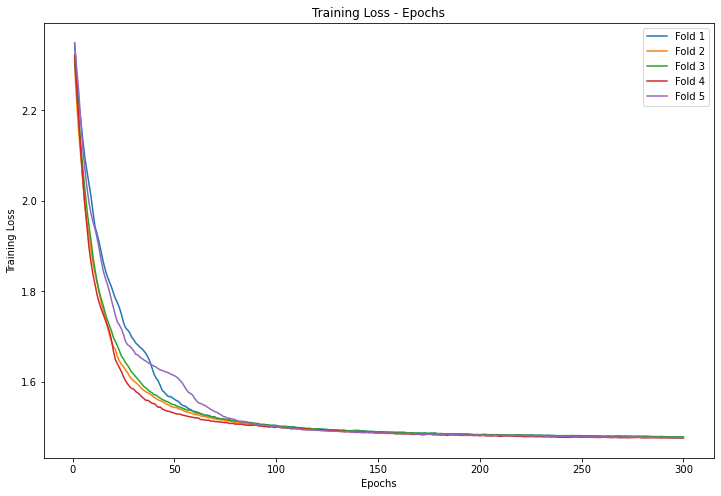

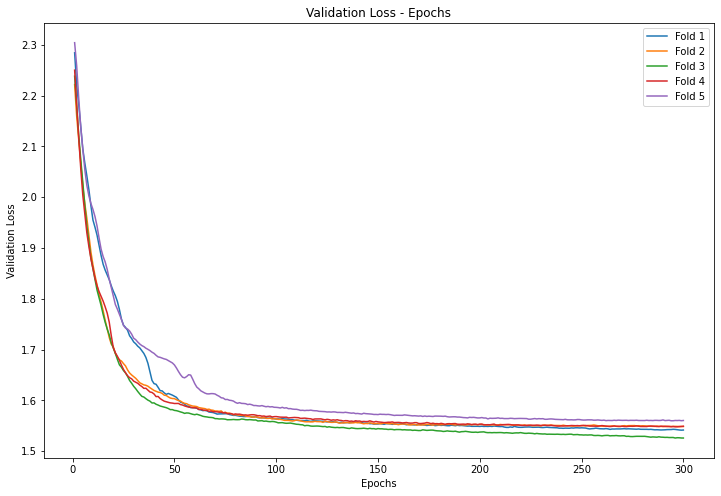

In [12]:
epochs = list(range(1,len(all_all_tr_loss[0])+1))

#Training loss
plt.figure(figsize=(12,8))
for i,losses in enumerate(all_all_tr_loss):
    plt.plot(epochs, losses, label=f'Fold {i+1}')
plt.title('Training Loss - Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()


#Validation loss
plt.figure(figsize=(12,8))
for i,losses in enumerate(all_all_valid_loss):
    plt.plot(epochs, losses, label=f'Fold {i+1}')
plt.title('Validation Loss - Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

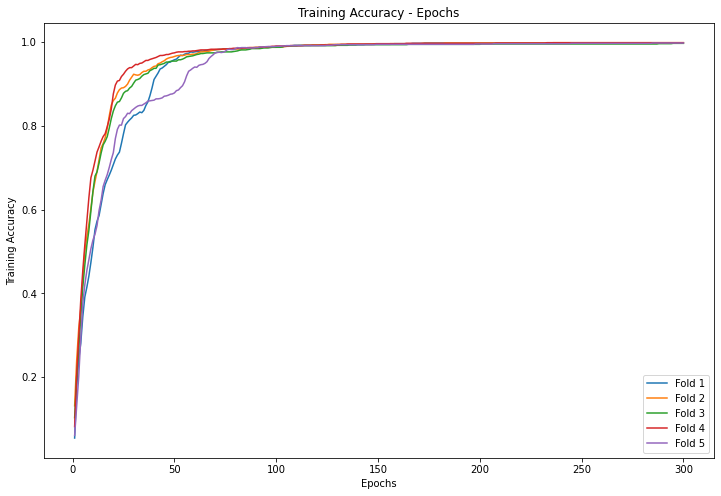

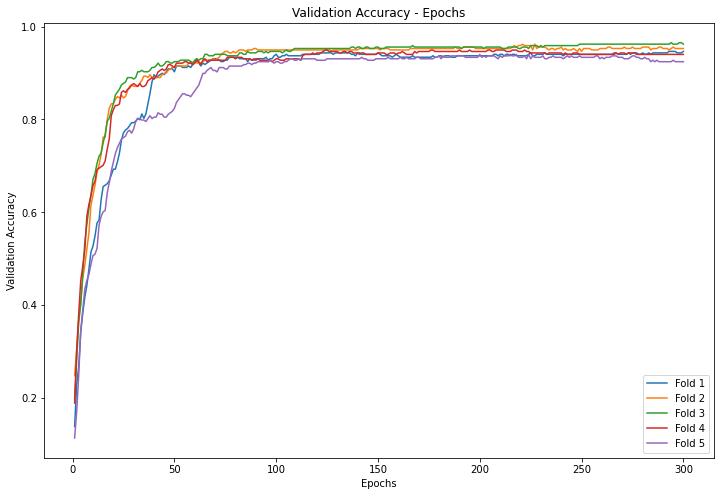

In [13]:
#Training Accuracy
plt.figure(figsize=(12,8))
for i,losses in enumerate(all_all_tr_acc):
    plt.plot(epochs, losses, label=f'Fold {i+1}')
plt.title('Training Accuracy - Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()


#Validation Accuracy
plt.figure(figsize=(12,8))
for i,losses in enumerate(all_all_valid_acc):
    plt.plot(epochs, losses, label=f'Fold {i+1}')
plt.title('Validation Accuracy - Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()